In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import numpy as np
import os

In [4]:
############ LOGO RESIZE


from PIL import Image

# Resize all logos to a consistent size (e.g., 100x100)
for path in logo_paths:
    img = Image.open(path)
    img = img.resize((250, 250))  # Resize to 100x100 pixels
    img.save(path)  # Overwrite with resized image

2025 done.
Downcasting floats.


/opt/miniconda3/envs/nfl-pbp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/nfl-pbp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


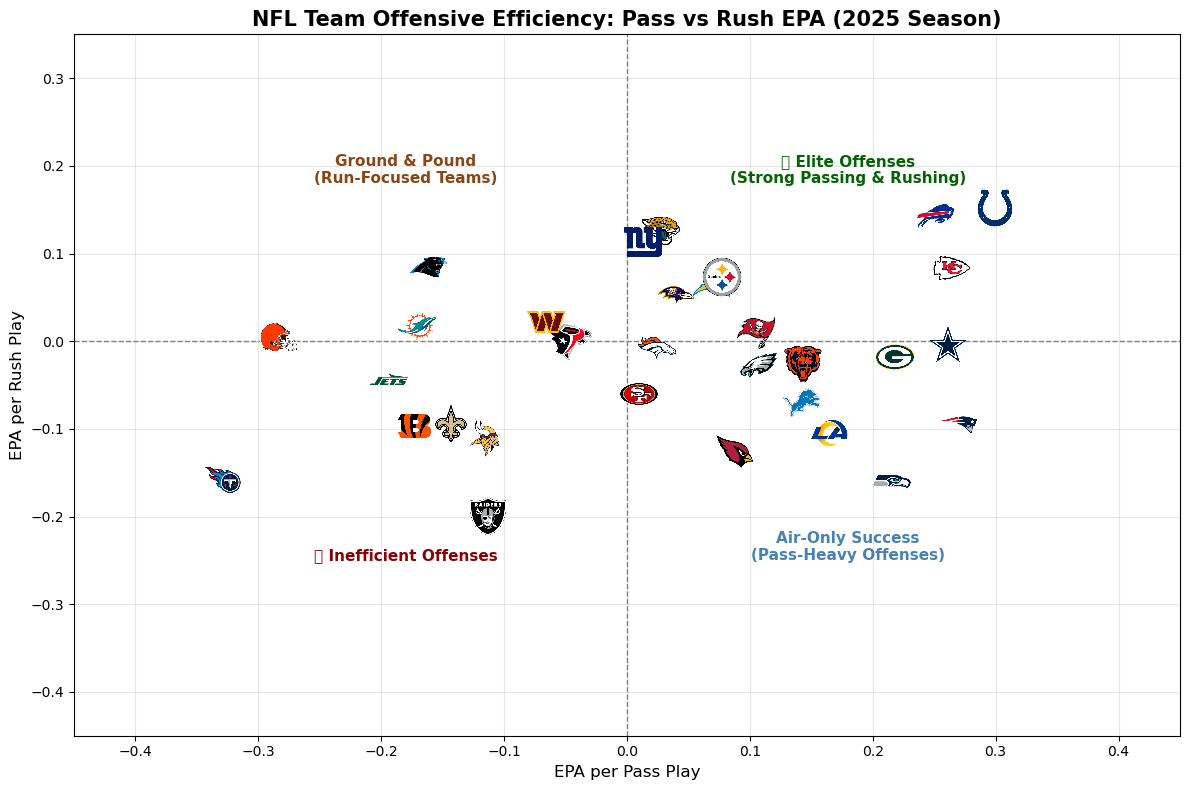

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import urllib.request
import nfl_data_py as nfl

# --- Load play-by-play data ---
pbp = nfl.import_pbp_data([2025])  

# --- Filter meaningful plays ---
pbp = pbp[
    (pbp['play_type'].isin(['pass', 'run'])) &
    (pbp['season_type'] == 'REG') &
    (pbp['yardline_100'].between(20, 80)) &
    (pbp['qtr'] <= 4)
]

# --- Compute EPA by team and play type ---
epa_by_team = pbp.groupby(['posteam', 'play_type'])['epa'].mean().reset_index()

# --- Pivot into pass_epa and rush_epa columns ---
epa_pivot = epa_by_team.pivot(index='posteam', columns='play_type', values='epa').reset_index()
epa_pivot.columns = ['posteam', 'pass_epa', 'rush_epa']

# --- Load team logos ---
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]

# --- Download logos locally ---
if not os.path.exists("logos"):
    os.makedirs("logos")

logo_paths = []
for team, url in zip(logos['team_abbr'], logos['team_logo_espn']):
    logo_path = f"logos/{team}.png"
    if not os.path.exists(logo_path):
        urllib.request.urlretrieve(url, logo_path)
    logo_paths.append(logo_path)

logos['logo_path'] = logo_paths

# --- Merge logos with EPA data ---
epa_with_logos = pd.merge(epa_pivot, logos, left_on='posteam', right_on='team_abbr', how='inner')

# --- Set up the plot ---
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

# --- Plot quadrant lines ---
ax.axhline(0, color='gray', lw=1, linestyle='--')
ax.axvline(0, color='gray', lw=1, linestyle='--')

# --- Add logos to scatterplot ---
for _, row in epa_with_logos.iterrows():
    try:
        logo = OffsetImage(plt.imread(row['logo_path']), zoom=0.12)
        ab = AnnotationBbox(logo, (row['pass_epa'], row['rush_epa']), frameon=False)
        ax.add_artist(ab)
    except FileNotFoundError:
        print(f"Missing logo for {row['posteam']}")

# --- Customize plot ---
ax.set_xlim(-0.45, 0.45)
ax.set_ylim(-0.45, 0.35)
ax.set_xlabel("EPA per Pass Play", fontsize=12)
ax.set_ylabel("EPA per Rush Play", fontsize=12)
ax.set_title("NFL Team Offensive Efficiency: Pass vs Rush EPA (2025 Season)", fontsize=15, weight='bold')

# --- Add quadrant labels for storytelling ---
plt.text(0.18, 0.18, "🏆 Elite Offenses\n(Strong Passing & Rushing)", 
         fontsize=11, ha='center', color='darkgreen', weight='bold')

plt.text(-0.18, 0.18, "Ground & Pound\n(Run-Focused Teams)", 
         fontsize=11, ha='center', color='saddlebrown', weight='bold')

plt.text(0.18, -0.25, "Air-Only Success\n(Pass-Heavy Offenses)", 
         fontsize=11, ha='center', color='steelblue', weight='bold')

plt.text(-0.18, -0.25, "🚫 Inefficient Offenses", 
         fontsize=11, ha='center', color='darkred', weight='bold')

# --- Light grid for clarity ---
plt.grid(alpha=0.3)

plt.show()


In [14]:
import nfl_data_py as nfl
pbp = nfl.import_pbp_data([2025])
print(pbp.columns[pbp.columns.str.contains("pass", case=False)])
print(pbp[['passer','passer_id','passer_player_name']].head(10))


2025 done.
Downcasting floats.
Index(['pass_length', 'pass_location', 'total_home_pass_epa',
       'total_away_pass_epa', 'total_home_pass_wpa', 'total_away_pass_wpa',
       'first_down_pass', 'incomplete_pass', 'pass_attempt', 'pass_touchdown',
       'complete_pass', 'passer_player_id', 'passer_player_name',
       'passing_yards', 'pass_defense_1_player_id',
       'pass_defense_1_player_name', 'pass_defense_2_player_id',
       'pass_defense_2_player_name', 'passer', 'passer_jersey_number', 'pass',
       'passer_id', 'xpass', 'pass_oe'],
      dtype='object')
      passer   passer_id passer_player_name
0       None        None               None
1       None        None               None
2       None        None               None
3   K.Murray  00-0035228           K.Murray
4   K.Murray  00-0035228           K.Murray
5       None        None               None
6       None        None               None
7       None        None               None
8       None        None       

In [20]:
qb_col = 'passer'  # or 'passer_player_name', etc.
pbp = pbp[pbp[qb_col].notna()].copy()
pbp['throw_depth'] = pbp['air_yards'].apply(throw_zone)

qb_depth_stats = (
    pbp.groupby([qb_col, 'posteam', 'throw_depth'])
    .agg(attempts=('play_id', 'count'),
         completions=('complete_pass', 'sum'))
    .reset_index()
)
qb_depth_stats.rename(columns={qb_col: 'passer_player_name'}, inplace=True)


2025 done.
Downcasting floats.


/var/folders/zy/zhqnxw4n3gx553hrq1vzrmz00000gn/T/ipykernel_17876/1910923039.py:178: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



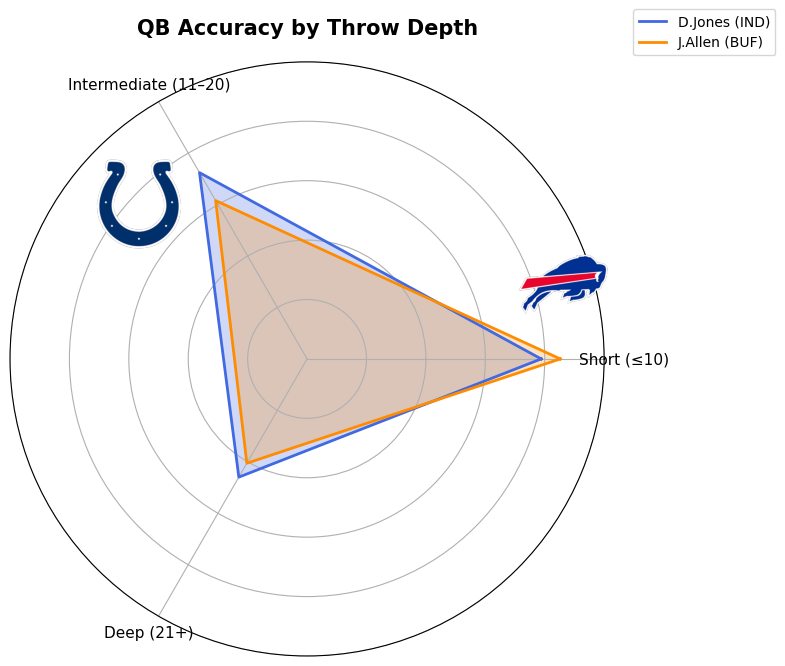

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nfl_data_py as nfl
import urllib.request, os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# -----------------------------
# 1️⃣ Load & Filter Passing Data
# -----------------------------
pbp = nfl.import_pbp_data([2025])  # change to [2024] if needed

pbp = pbp[
    (pbp['play_type'] == 'pass') &
    (pbp['season_type'] == 'REG') &
    (pbp['air_yards'].notna()) &
    (pbp['passer_player_name'].notna())
].copy()

# -----------------------------
# 2️⃣ Define Throw Depth Categories
# -----------------------------
def throw_zone(air_yards):
    if air_yards <= 5:
        return "Short (≤5)"
    elif air_yards <= 15:
        return "Intermediate (6–15)"
    else:
        return "Deep (16+)"

pbp['throw_depth'] = pbp['air_yards'].apply(throw_zone)

# -----------------------------
# 3️⃣ Compute QB Accuracy by Zone
# -----------------------------
qb_depth_stats = (
    pbp.groupby(['passer_player_name', 'posteam', 'throw_depth'])
    .agg(attempts=('play_id', 'count'),
         completions=('complete_pass', 'sum'))
    .reset_index()
)
qb_depth_stats['completion_pct'] = qb_depth_stats['completions'] / qb_depth_stats['attempts']

# Lower the attempts threshold so we don't accidentally exclude our target QBs
attempts_by_qb = qb_depth_stats.groupby('passer_player_name')['attempts'].sum()
valid_qbs = attempts_by_qb[attempts_by_qb >= 50].index  # 50 is safer for small-sample runs
qb_depth_stats = qb_depth_stats[qb_depth_stats['passer_player_name'].isin(valid_qbs)].copy()

# -----------------------------
# 4️⃣ Add Team Logos
# -----------------------------
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]

if not os.path.exists("logos"):
    os.makedirs("logos")

for team, url in zip(logos['team_abbr'], logos['team_logo_espn']):
    logo_path = f"logos/{team}.png"
    if not os.path.exists(logo_path):
        try:
            urllib.request.urlretrieve(url, logo_path)
        except Exception as e:
            print(f"Failed to download {team} logo: {e}")

logos['logo_path'] = [f"logos/{team}.png" for team in logos['team_abbr']]
qb_depth_stats = qb_depth_stats.merge(logos, left_on='posteam', right_on='team_abbr', how='left')

# -----------------------------
# 5️⃣ Compare Two QBs — Robust Radar Chart
# -----------------------------
def find_qb(df, name):
    """
    Try to find the QB in df by exact name, case-insensitive, or substring.
    Returns the canonical name found (index) or None.
    """
    names = df['passer_player_name'].unique()
    # Exact
    if name in names:
        return name
    # Case-insensitive exact
    for n in names:
        if n.lower() == name.lower():
            return n
    # Startswith or contains
    for n in names:
        if n.lower().startswith(name.lower()) or name.lower() in n.lower():
            return n
    return None

def get_qb_profile(df, qb_name):
    """
    Returns list of completion % values for the three categories (Short, Intermediate, Deep)
    in order, filling missing zones with np.nan, plus team and logo path.
    """
    sub = df[df['passer_player_name'] == qb_name]
    if sub.empty:
        return None

    categories = ["Short (≤5)", "Intermediate (6–15)", "Deep (16+)"]
    vals = []
    for c in categories:
        v = sub.loc[sub['throw_depth'] == c, 'completion_pct']
        vals.append(float(v.iloc[0]) if not v.empty else np.nan)

    # get team and logo (take the most common teammate if duplicates)
    team = sub['posteam'].mode().iloc[0] if not sub['posteam'].mode().empty else None
    logo_path = sub['logo_path'].mode().iloc[0] if 'logo_path' in sub.columns and not sub['logo_path'].mode().empty else None
    return vals, team, logo_path

def radar_compare(qb1_input, qb2_input, df):
    categories = ["Short (≤10)", "Intermediate (11–20)", "Deep (21+)"]
    N = len(categories)

    # find canonical names in df
    qb1_name = find_qb(df, qb1_input)
    qb2_name = find_qb(df, qb2_input)

    if qb1_name is None:
        print(f"Could not find QB matching '{qb1_input}' in the data.")
        return
    if qb2_name is None:
        print(f"Could not find QB matching '{qb2_input}' in the data.")
        return

    qb1_profile = get_qb_profile(df, qb1_name)
    qb2_profile = get_qb_profile(df, qb2_name)

    if qb1_profile is None or qb2_profile is None:
        print("One of the QBs has no profile data after filtering.")
        return

    qb1_vals, team1, logo1 = qb1_profile
    qb2_vals, team2, logo2 = qb2_profile

    # Replace nan with 0 for plotting simplicity (or keep np.nan to show gaps)
    qb1_plot = [0 if np.isnan(v) else v for v in qb1_vals]
    qb2_plot = [0 if np.isnan(v) else v for v in qb2_vals]

    # Close the loop
    qb1_plot += qb1_plot[:1]
    qb2_plot += qb2_plot[:1]

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    # Create plot
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

    # Plot QB1
    ax.plot(angles, qb1_plot, color='royalblue', linewidth=2, label=f"{qb1_name} ({team1})")
    ax.fill(angles, qb1_plot, color='royalblue', alpha=0.25)

    # Plot QB2
    ax.plot(angles, qb2_plot, color='darkorange', linewidth=2, label=f"{qb2_name} ({team2})")
    ax.fill(angles, qb2_plot, color='darkorange', alpha=0.25)

    # Axis setup
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)
    plt.title("QB Accuracy by Throw Depth", fontsize=15, weight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Add logos in inset axes (safe coordinates in figure fraction space)
    if logo1 and os.path.exists(logo1):
        ax_in1 = fig.add_axes([0.12, 0.60, 0.12, 0.12])  # [left, bottom, width, height]
        img1 = plt.imread(logo1)
        ax_in1.imshow(img1)
        ax_in1.axis('off')

    if logo2 and os.path.exists(logo2):
        ax_in2 = fig.add_axes([0.65, 0.50, 0.12, 0.12])
        img2 = plt.imread(logo2)
        ax_in2.imshow(img2)
        ax_in2.axis('off')

    plt.tight_layout()
    plt.show()

# -----------------------------
# 6️⃣ Run for Daniel Jones vs Josh Allen
# -----------------------------
radar_compare("D.Jones", "J.Allen", qb_depth_stats)


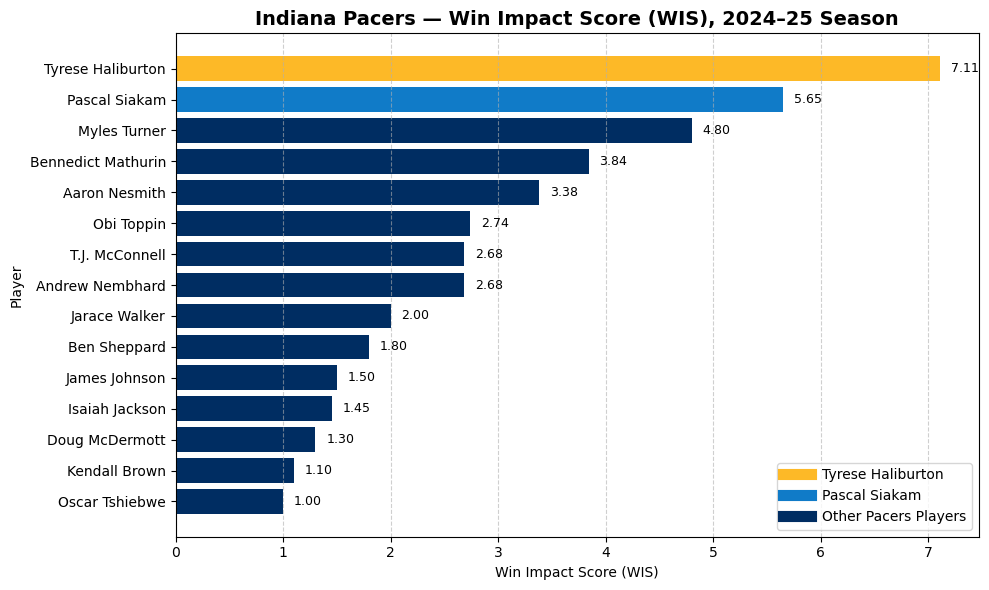

In [18]:
## VISUAL IS NOT FOR BIG DATA BOWL PROJECT

import matplotlib.pyplot as plt

# Data
players = [
    "Tyrese Haliburton", "Pascal Siakam", "Myles Turner", "Bennedict Mathurin", 
    "Aaron Nesmith", "Obi Toppin", "T.J. McConnell", "Andrew Nembhard",
    "Jarace Walker", "Ben Sheppard", "James Johnson", "Isaiah Jackson",
    "Doug McDermott", "Kendall Brown", "Oscar Tshiebwe"
]

wis_scores = [7.11, 5.65, 4.80, 3.84, 3.38, 2.74, 2.68, 2.68, 2.00, 1.80, 1.50, 1.45, 1.30, 1.10, 1.00]

# Sort players by WIS descending
players_sorted, wis_sorted = zip(*sorted(zip(players, wis_scores), key=lambda x: x[1], reverse=True))

# Define colors
colors = []
for player in players_sorted:
    if player == "Tyrese Haliburton":
        colors.append("#FDB927")  # gold
    elif player == "Pascal Siakam":
        colors.append("#107BC8")  # red
    else:
        colors.append("#002D62")  # blue

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(players_sorted, wis_sorted, color=colors)
plt.gca().invert_yaxis()

# Labels and title
plt.title("Indiana Pacers — Win Impact Score (WIS), 2024–25 Season", fontsize=14, weight='bold')
plt.xlabel("Win Impact Score (WIS)")
plt.ylabel("Player")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ensure chart starts at 0.0
plt.xlim(left=0)

# Display values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va='center', fontsize=9)

# Add legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="#FDB927", lw=8, label="Tyrese Haliburton"),
        plt.Line2D([0], [0], color="#107BC8", lw=8, label="Pascal Siakam"),
        plt.Line2D([0], [0], color="#002D62", lw=8, label="Other Pacers Players")
    ],
    loc="lower right"
)

plt.tight_layout()
plt.show()